## Import the necessary libraries

In [1]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np

In [2]:
import cv2

In [3]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image



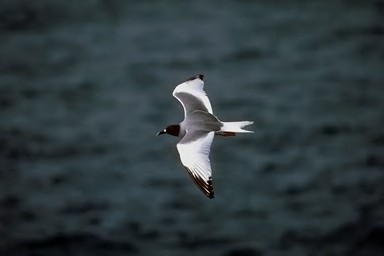

In [4]:
real_image_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00010.jpg'
Image.open(real_image_path)

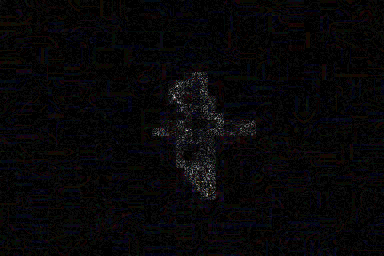

In [5]:
convert_to_ela_image(real_image_path, 85)

In [29]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0


In [30]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

## Processing Authentic images

In [31]:
import random
count = 0
path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
#         count+=1
#         if count < 1000:
#             pass
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)  
        if len(Y) % 1000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 1000 == 0:
        break

random.shuffle(X)
# X = X[:2100]
# Y = Y[:2100]
print(len(X), len(Y))

Processing 1000 images
1000 1000


In [32]:
len(X),len(Y)

(1000, 1000)

## Processing Tampering Images

In [33]:
x_t, y_t = [], []

In [34]:
path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
count = 0
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
#         count += 1
#         if count < 1000:
#             pass
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
        if len(Y) % 2000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 1700 == 0:
        break

print(len(X), len(Y))


Processing 2000 images
2000 2000


In [35]:
from keras.utils.np_utils import to_categorical

## Shuffling the data

In [36]:
from sklearn.utils import shuffle
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

## Resizing the image to fit the data

In [37]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [38]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

1600 1600
400 400


In [39]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

model1 = build_model()
model1.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               29491456  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [53]:
def build_model():
    model = Sequential()
    model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=512,activation="relu"))
    model.add(Dense(units=256,activation="relu"))
    model.add(Dense(units=2, activation="softmax")) 

    print(model.summary())
    return model

model = build_model()
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 32, 32, 512)      

In [40]:
from tensorflow.keras.optimizers import Adam

## Declaring the params

In [41]:
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr, decay = init_lr/50)

In [54]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [43]:
model1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

## Training the model

In [55]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 10

history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_val, Y_val),
    verbose=2)

# score = model.evaluate(x_test, y_test)
# print('Test accuracy:', score[1])

Epoch 1/10
100/100 - 6s - loss: 0.7009 - accuracy: 0.5269 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 2/10
100/100 - 5s - loss: 0.6163 - accuracy: 0.6750 - val_loss: 0.5044 - val_accuracy: 0.7700
Epoch 3/10
100/100 - 5s - loss: 0.4839 - accuracy: 0.7856 - val_loss: 0.4337 - val_accuracy: 0.8275
Epoch 4/10
100/100 - 5s - loss: 0.4378 - accuracy: 0.8163 - val_loss: 0.4452 - val_accuracy: 0.8050
Epoch 5/10
100/100 - 5s - loss: 0.4065 - accuracy: 0.8288 - val_loss: 0.4267 - val_accuracy: 0.8225
Epoch 6/10
100/100 - 5s - loss: 0.3861 - accuracy: 0.8444 - val_loss: 0.3988 - val_accuracy: 0.8400
Epoch 7/10
100/100 - 5s - loss: 0.3796 - accuracy: 0.8475 - val_loss: 0.3872 - val_accuracy: 0.8400
Epoch 8/10
100/100 - 5s - loss: 0.3640 - accuracy: 0.8575 - val_loss: 0.4289 - val_accuracy: 0.8125
Epoch 9/10
100/100 - 5s - loss: 0.3646 - accuracy: 0.8600 - val_loss: 0.3779 - val_accuracy: 0.8450
Epoch 10/10
100/100 - 5s - loss: 0.3394 - accuracy: 0.8675 - val_loss: 0.3784 - val_accuracy: 0.8425

In [44]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 10

history = model1.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_val, Y_val),
    verbose=2)

# score = model.evaluate(x_test, y_test)
# print('Test accuracy:', score[1])

Epoch 1/10
100/100 - 2s - loss: 0.6235 - accuracy: 0.5169 - val_loss: 0.5137 - val_accuracy: 0.8100
Epoch 2/10
100/100 - 1s - loss: 0.4702 - accuracy: 0.8169 - val_loss: 0.4264 - val_accuracy: 0.8350
Epoch 3/10
100/100 - 1s - loss: 0.3896 - accuracy: 0.8537 - val_loss: 0.4205 - val_accuracy: 0.8075
Epoch 4/10
100/100 - 1s - loss: 0.3543 - accuracy: 0.8612 - val_loss: 0.3740 - val_accuracy: 0.8500
Epoch 5/10
100/100 - 1s - loss: 0.3326 - accuracy: 0.8750 - val_loss: 0.3201 - val_accuracy: 0.8800
Epoch 6/10
100/100 - 1s - loss: 0.3163 - accuracy: 0.8825 - val_loss: 0.3396 - val_accuracy: 0.8650
Epoch 7/10
100/100 - 1s - loss: 0.2907 - accuracy: 0.8938 - val_loss: 0.3003 - val_accuracy: 0.8825
Epoch 8/10
100/100 - 1s - loss: 0.2759 - accuracy: 0.8969 - val_loss: 0.3200 - val_accuracy: 0.8725
Epoch 9/10
100/100 - 1s - loss: 0.2404 - accuracy: 0.9162 - val_loss: 0.2623 - val_accuracy: 0.9025
Epoch 10/10
100/100 - 1s - loss: 0.2189 - accuracy: 0.9200 - val_loss: 0.2478 - val_accuracy: 0.9025

In [ ]:
json_file = model.to_json()
with open('./mymodel.json', "w") as file:
   file.write(json_file)

In [ ]:
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)